# A2. Crawling and classifying YouTube comments from Greek pages

## I. Language detection
1. Build a language detector (Greek/Greeklish/English/Other) using RegExps.
2. Create a ground truth evaluation dataset and assess your classifier. (Hint: you are free to
manually extract data from online sources.) This dataset will be submitted as a CSV named as
gold.csv.

In [14]:
import pandas as pd
import re

df = pd.read_csv('input.csv', sep=';')
df.sample(5)

,text,human,machine
269,Wie geht es dir?,4,0
147,Have a good day,3,0
65,Yparxei kapoia guild pou tha xekinisei ston ON...,2,0
60,Για να έχουμε 5.1 ήχο στις ταινίες πρέπει να ε...,1,0
29,Για να μην ανοίγονται λοιπόν συνεχώς καινούργι...,1,0


In [2]:
def detect_language(sentence):
    try: 
        sentence.split()
    except AttributeError:
        return 4
    else:
        greek_word_pattern = re.compile(r'\b[\u0370-\u03FF\u1F00-\u1FFF]+\b')
        english_word_pattern = re.compile(r'\b[A-Za-z\']+\'?[A-Za-z]*\b')
    
        greek_matches = greek_word_pattern.findall(sentence)
    
        if greek_matches:
            return 1
        else:
            greeklish_pattern1 = r'\b\w+(ai|ei|oia|oio|oios|oun|ete|otan|zw|xw|nw|vw)\b'
            greeklish_pattern2 = r'\b(tha|h|oi|sto|ston|gia|kai|ti|alla|apo|afou|egine|edw|eipe|eixe|ena|thn|oxi|giati|tis|sou|mou|tou)\b'
            # Use re.findall to find all matches in the input text
            endsWith = re.findall(greeklish_pattern1, sentence)
            contains = re.findall(greeklish_pattern2, sentence)
    
            if endsWith or contains:
                return 2
            else:
                hasEnglishWords = english_word_pattern.findall(sentence)
                allWordsAreEnglish = len(sentence.split()) == len(hasEnglishWords)
                
                if hasEnglishWords and allWordsAreEnglish:
                    return 3
                else:   
                    return 4

In [4]:
df.machine = df.text.apply(detect_language)

# Export the DataFrame to a CSV file
df.to_csv('gold.csv', index=False)

In [6]:
df.sample(5)

,text,human,machine
238,អ្នករបស់អ្នកមានសមត្ថភាពប៉ុន្មាន?,4,4
91,"emeis paizoume icecrown alliance an 8elete, ei...",2,2
195,I'm surprised,3,3
144,It's okay,3,3
20,"Σε κάθε περίπτωση , το μηχάνημα σου δεν έχει ...",1,1


In [26]:
# Count the number of correct predictions
correct_predictions = (df['human'] == df['machine']).sum()
# Calculate accuracy
total_samples = len(df)
accuracy = correct_predictions / total_samples

print(f"Accuracy: {accuracy:.2%}")

Accuracy: 93.43%


## II. Crawl YouTube for videos with Greek posts
1. Apply your language detector to the page’s title.
2. Parse all the comments of the page but only if the title is in Greek/Greeklish.
3. Use a strategy to jump to other pages that *will likely* have Greek/Greeklish titles.
4. Form a CSV with the crawled information, to be submitted named as crawl.csv.

In [5]:
import time
#!pip install selenium
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import re


In [6]:
def scrape_youtube_comments(video_url, commentList, max_pages=3, current_page=1):
    if current_page > max_pages:
        return

    # Set up Chrome WebDriver
    driver = webdriver.Firefox()
    time.sleep(3)  # Wait for the page to load


    wait = WebDriverWait(driver, 10)
    # Open the YouTube video URL
    driver.get(video_url)
    # driver.implicitly_wait(30)
    time.sleep(5)  # Wait for the page to load

    # Scrape page
    content = driver.page_source#.encode("utf-8").strip()
    soup = BeautifulSoup(content, 'lxml')

    # Scrape Title
    myMainTitle = soup.find("yt-formatted-string", class_="style-scope ytd-watch-metadata").get_text()
    flagToScrape = detect_language(myMainTitle)

    # If the title is in Greek
    if flagToScrape == 1 or flagToScrape == 2:
        # Scroll down to load comments (adjust the number of scrolls as needed)
        for _ in range(5):  # Scroll down 5 times; adjust as needed
            # driver.implicitly_wait(30)
            driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)
            time.sleep(2)  # Wait for the page to load

        # Find and extract the comments
        try:
            comments = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "#comment #content-text")))
            for comment in comments:
                commentList.append(comment.text.strip())
        except Exception as e:
            # Handle the exception if no comments are found
            print("An error occurred while extracting comments:", str(e))
            
        # Find all the recommended videos
        vids = soup.find_all("a", class_="yt-simple-endpoint style-scope ytd-compact-video-renderer")

        for vid in vids:
            newTitle = vid.find("span", id='video-title').text.strip()
            flagToJump = detect_language(newTitle)
            # If title of the recommended video is in Greek
            if flagToJump == 1 or flagToJump == 2:
                break
            
        newVideo = vid.get("href")
        video_url = 'https://www.youtube.com' + newVideo
        driver.quit()
        scrape_youtube_comments(video_url, commentList, max_pages, current_page + 1)
        
        return

In [7]:
# Jump into the rabbit hole:
video_url = "https://www.youtube.com/watch?v=cUuPL22XKfE"
commentList = []
scrape_youtube_comments(video_url, commentList, max_pages=10, current_page=1)

In [8]:

df = pd.DataFrame(commentList)
df.to_csv('crawl.csv', index=False)


### III Improve language detection
1. Benchmark text classification (scikit) algorithms for the language detection task,
outperforming your rule-based classifier and naive baselines. For evaluation, use the dataset
created in the 1st step. (Hint: you are free to annotate more data or augment your training
dataset otherwise.)


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from time import time
import re
import warnings

In [4]:
def detect_language(sentence):
    try: 
        sentence.split()
    except AttributeError:
        return 4
    else:
        greek_word_pattern = re.compile(r'\b[\u0370-\u03FF\u1F00-\u1FFF]+\b')
        english_word_pattern = re.compile(r'\b[A-Za-z\']+\'?[A-Za-z]*\b')
    
        greek_matches = greek_word_pattern.findall(sentence)
    
        if greek_matches:
            return 1
        else:
            greeklish_pattern1 = r'\b\w+(ai|ei|oia|oio|oios|oun|ete|otan|zw|xw|nw|vw)\b'
            greeklish_pattern2 = r'\b(tha|h|oi|sto|ston|gia|kai|ti|alla|apo|afou|egine|edw|eipe|eixe|ena|thn|oxi|giati|tis|sou|mou|tou)\b'
            # Use re.findall to find all matches in the input text
            endsWith = re.findall(greeklish_pattern1, sentence)
            contains = re.findall(greeklish_pattern2, sentence)
    
            if endsWith or contains:
                return 2
            else:
                hasEnglishWords = english_word_pattern.findall(sentence)
                allWordsAreEnglish = len(sentence.split()) == len(hasEnglishWords)
                
                if hasEnglishWords and allWordsAreEnglish:
                    return 3
                else:   
                    return 4

In [5]:
def benchmark(model, vectorizer, model_name=None) :
    predictions, gold = [], []
    t0 = time()
    for i in range(5): # 5-fold Monte Carlo Cross Validation
        train, test = train_test_split(df, test_size=0.2, random_state=2023+i)
        clf = model
        # vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2,10), max_features=30)
        X = vectorizer.fit_transform(train.text.values)
        clf.fit(X, train.human.values)
        predictions.append(clf.predict(vectorizer.transform(test.text.values)))
        gold.append(test.human.values) 
        
    results = {'f1': [f1_score(gold[k], 
                               predictions[k], 
                               zero_division=0, 
                               average='macro') 
                      for k in range(5)]}
    results_pd = pd.DataFrame(results)
    test_time = time() - t0
    print(f'Macro F1: {results_pd.f1.mean():.2f} ± {results_pd.f1.sem():.2f} time: {test_time:.2f}')
    return results_pd.f1.mean(), model_name, test_time, clf


In [6]:
df = pd.read_csv('gold.csv')
df = df.dropna(how='all')

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2,10), max_features=30)

# Assess classifiers
results = []
for clf, name in (
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    #(RandomForestClassifier(), "Random Forest"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, vectorizer, model_name = name))

Logistic Regression
Macro F1: 0.81 ± 0.02 time: 1.38
Ridge Classifier
Macro F1: 0.83 ± 0.02 time: 1.48
kNN
Macro F1: 0.62 ± 0.02 time: 1.84
Complement naive Bayes
Macro F1: 0.55 ± 0.03 time: 1.32


2. Apply your best classifier to each post to annotate mechanically the language of each
comment and explore the annotated data. (Hint: use visualisations and extract insightful
findings that would not be visible without your mechanical annotations.) A report named
report.pdf should comprise these.

In [9]:
# Best model => Ridge Classifier
clf = results[1][3]

# Read scraped comments
df = pd.read_csv('crawl.csv')
df = df.dropna(how='all')
df.rename(columns={'0': 'text'}, inplace=True)    
df['regex'] = df.text.apply(detect_language) # set as gold

# Classify using best model
X = vectorizer.fit_transform(df.text.values)
df['RC'] = clf.predict(X)


In [10]:
# Compare
print(f' Accuracy: {accuracy_score(df.regex, df.RC)*100:.2f}%')
print(df.sample(20))

 Accuracy: 86.47%
                                                  text  regex  RC
569  Εξαιρετική ανάλυση, πολλά από αυτά τα είχα στο...      1   1
490   Μακάρι να μην τελείωνε αυτό το επεισόδιο λέμε!!!      1   1
476  Το κανάλι σου είνα φοβερό .!!! Μπορείς να κάνε...      1   1
183  Ίσως η Ελένη δεν περιγράφεται όχι μόνο για να ...      1   1
317  Κρατάμε ως πρώτο δεδομένο     την κατάταξη  το...      1   1
433  Τώρα τελευταία, εντελώς τυχαία έπεσα στο κανάλ...      1   1
686                                              11:19      4   4
343  Συνέχισε αυτό που κάνεις γιατι σου βγαίνει φυσ...      1   1
636  Μεγάλος Αναποφάσιστος Λαϊκός Ανεξάρτητος Και Α...      1   1
612   Ό,τι καλύτερο έχει βγεις στην ελληνική τηλεόραση      1   2
405  Μου αρέσουν όλες αυτές οι πληροφορίες και προσ...      1   1
668        Εγω τώρα που το βλέπω μια μέρα πριν αρχίσει      1   1
432  Ως γέννημα θρέμμα της Ελευσίνας θα ήθελα να πω...      1   1
256  Ωωω τέλεια ανυπομονώ να το δω \n️\nΈσκασε νέο ...    

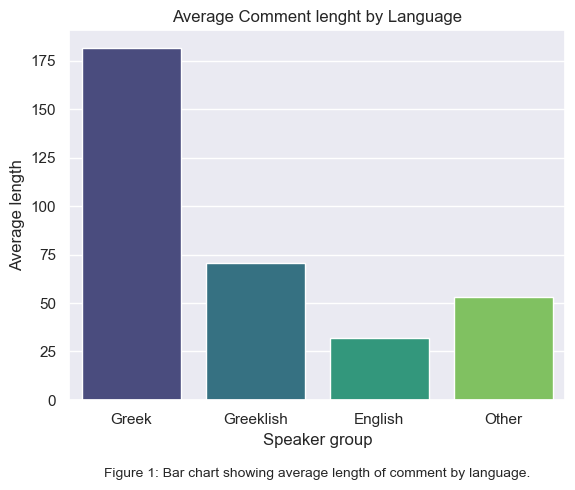

In [13]:
# Ignore specific warning
warnings.filterwarnings("ignore", category=FutureWarning)

df['text_length'] = df.text.apply(len)
average_values = df.groupby('RC')['text_length'].mean()

# Seaborn bar chart
x = ['Greek', 'Greeklish', 'English', 'Other']
y = average_values.values
sns.barplot(x=x, y=y, palette='viridis');
plt.title('Average Comment lenght by Language');
plt.xlabel('Speaker group');
plt.ylabel('Average length');
# Add a caption
plt.text(0.5, -0.2, 'Figure 1: Bar chart showing average length of comment by language.', 
         horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes, fontsize=10);
plt.show()


### IV Toxicity classification
1. Use prompting to create a toxicity classifier that classifies each post from 1 (not) to 5
(toxic). Report all your prompts (from the one your started to the one you ended up with) as a
PDF named prompts.pdf.

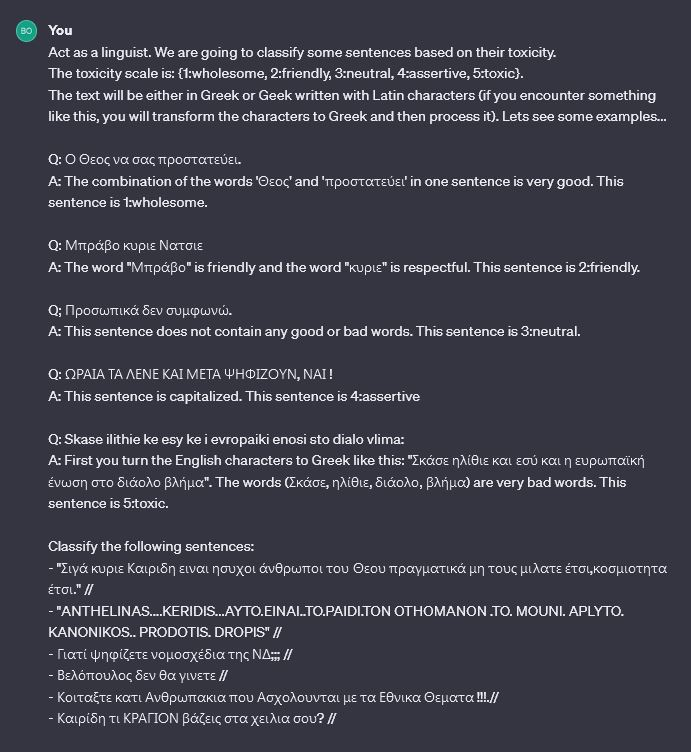

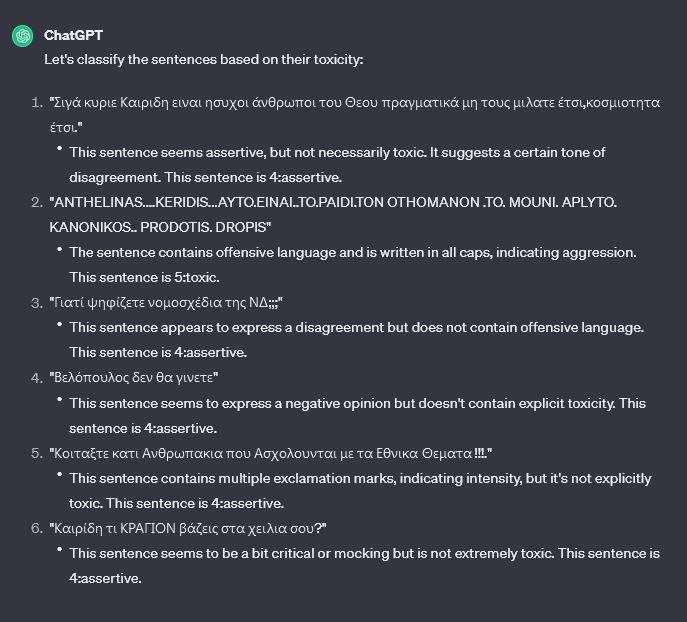

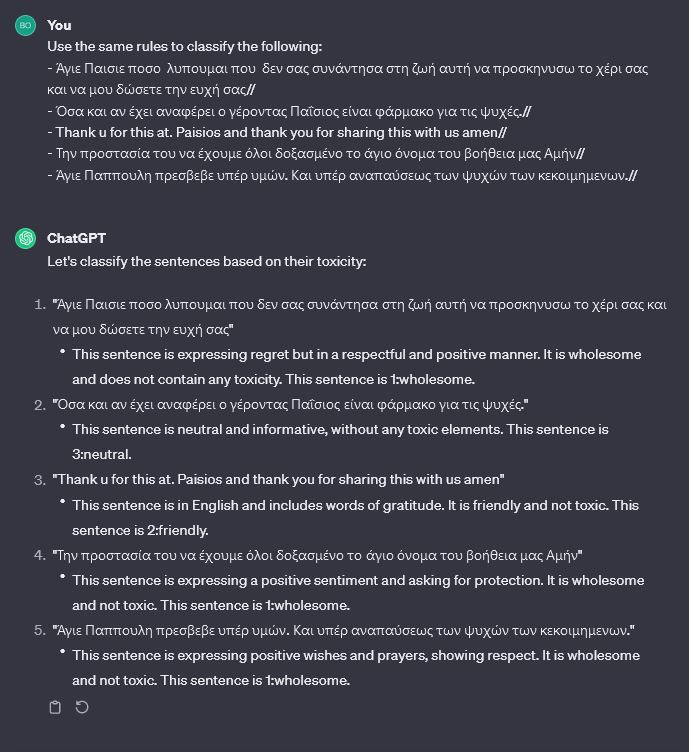